# Recurrent Neural Network - LSTM


## Part 1 - Data Preprocessing

---



### Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
#from lifelines.utils import concordance_index

from keras.layers import Dense, Activation, LSTM
from keras.layers import  Dropout
from keras import regularizers
from keras import backend as tf

import keras.backend as K
import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *


import sys, time, random, json, pickle, itertools
import networkx as nx
import matplotlib
import scipy.stats
from sklearn.neighbors import KernelDensity
import statsmodels.stats.correlation_tools as stm
from scipy.stats import norm

import torch, torchvision
from sklearn.preprocessing import MinMaxScaler
np.random.seed(12345678)

### Import the database

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import os
workdir_path = '/content/drive/MyDrive/Summer 2022 RA'
os.chdir(workdir_path)

Mounted at /content/drive


In [3]:
# Define data files
datadir = 'dataverse_files/'
datafn_tmpl = datadir + 'sms-call-internet-mi-%4d-%02d-%02d.txt'
datafn_idxs = [ (2013, 11, i) for i in range(1,5) ]  #+ [ (2013, 12, i) for i in range(1, 32) ] + [ (2014, 1, 1) ]
datafns = [ datafn_tmpl % x for x in datafn_idxs ]
print("Number of non-existent files:", sum([ not os.path.exists(fn) for fn in datafns ]))
outfn = datadir[:-1] + '-internet.csv'

# dataset_train = pd.read_csv('train.csv')
# training_set = dataset_train.iloc[:, 1:2].values #only column of the series itself

Number of non-existent files: 0


In [5]:
# Pick the data files to index
fns = datafns#[:10]

### Read and Preprocess Data (Save to CSV)

In [6]:
data = pd.DataFrame()
for fn in fns:
    #print('Reading file ', fn, ' ...')
    df = pd.read_csv(fn, sep="\t", header=None, names=['grid', 'time', 'country', 'sms-in', 'sms-out', 'call-in', 'call-out', 'internet'])
    df = df[ df['country'] == 39 ].drop(columns=['country', 'sms-in', 'sms-out', 'call-in', 'call-out']).fillna(0)
    data = pd.concat([ data, df ])
data = data.sort_values(by=['time', 'grid']).reset_index(drop=True)

In [7]:
# Statistics of the dataset
print("# 10min slots:", len(data['time'].unique()) )
print("Mean internet:", data['internet'].mean())
print("(Min, 5%, 25%, median, 75%, 95%, max) internet:")
print( ( data['internet'].min(), data['internet'].quantile(0.05), data['internet'].quantile(0.25), data['internet'].median(), data['internet'].quantile(0.75), data['internet'].quantile(0.95), data['internet'].max() )  )

# 10min slots: 576
Mean internet: 61.471731830821824
(Min, 5%, 25%, median, 75%, 95%, max) internet:
(0.0, 2.969617072813118, 10.982975646323265, 27.925311205624425, 65.51675429623229, 235.37264641289994, 7936.265379884158)


In [8]:
data.to_csv(outfn)

### Load Data

In [9]:
data = pd.read_csv(outfn, index_col=0)
print("# 10min slots:", len(data['time'].unique()) )

# 10min slots: 576


In [10]:
# Find a grid with the maximum total demand for the prediction task
max_dmd_grid = sorted([ ( data[ data['grid']==i ]['internet'].sum(), i ) for i in range(1, 10001) ])
max_dmd_grid = list(reversed(max_dmd_grid))
gridx = max_dmd_grid[0][1]
#max_dmd_grid[:30]

In [11]:
datax = data[ data['grid'] == gridx ].reset_index(drop=True)

<Axes: >

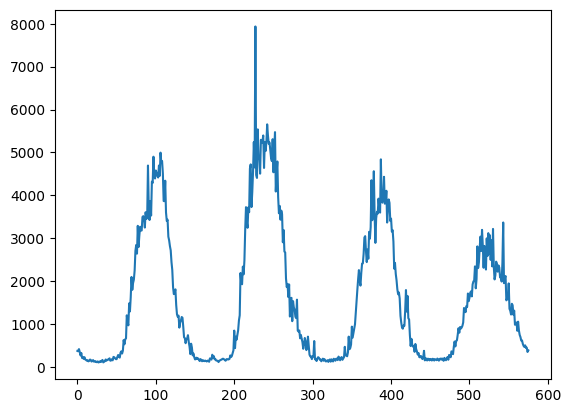

In [12]:
# Plot the data
datax['internet'].plot()

### Learning and Prediction

### Preparing data

In [13]:
# Parameters
total_size = len(datax.index)
train_size = int(total_size * 2 / 3)
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)

Train size: 384 Test size: 192


In [14]:
# Train/test split
#x = datax['internet'].to_numpy()

train = datax[:train_size]
test = datax[train_size:]
dataset_train = train
training_set = dataset_train.iloc[:, 2:3].values

### Time Series Graph

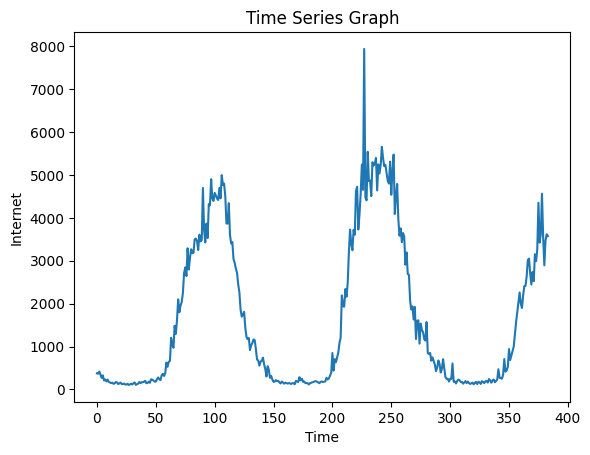

In [15]:
plt.plot(training_set)
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Graph")
plt.show()

# plt.plot(datax['internet'])
# plt.xlabel("Time")
# plt.ylabel("Internet")
# plt.title("Time Series Graph")
# plt.show()

### Normalization



In [16]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Create the data structure with window 15 and output 1

In [17]:
window = 144
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [18]:
X_train.shape

(240, 144)

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [20]:
X_train.shape

(240, 144, 1)

## Part 2 - Construction of the RNN

### Construction of the complete network

In [21]:
# Initialize the RNN





regressor = Sequential()
regressor.add(LSTM(units=60, activation = 'relu',return_sequences=True, input_shape= (X_train.shape[1],1)))
regressor.add(LSTM(units=60, activation = 'relu', return_sequences = True))

regressor.add(LSTM(units=40, activation = 'relu',return_sequences = True))

regressor.add(LSTM(units=40, activation = 'relu',return_sequences = False))
regressor.add(Dense(units = 1))

# Compile the network
regressor.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

# Summarize the network
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144, 60)           14880     
                                                                 
 lstm_1 (LSTM)               (None, 144, 60)           29040     
                                                                 
 lstm_2 (LSTM)               (None, 144, 40)           16160     
                                                                 
 lstm_3 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 73081 (285.47 KB)
Trainable params: 73081 (285.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training

In [22]:
regressor.fit(X_train, y_train, epochs = 50, batch_size = 7)


Epoch 1/50
35/35 [==============================] - 46s 1000ms/step - loss: 0.0626 - accuracy: 0.0000e+00
Epoch 2/50
35/35 [==============================] - 37s 1s/step - loss: 0.0230 - accuracy: 0.0000e+00
Epoch 3/50
35/35 [==============================] - 33s 951ms/step - loss: 0.0095 - accuracy: 0.0000e+00
Epoch 4/50
35/35 [==============================] - 35s 996ms/step - loss: 0.0069 - accuracy: 0.0042
Epoch 5/50
35/35 [==============================] - 33s 945ms/step - loss: 0.0089 - accuracy: 0.0000e+00
Epoch 6/50
35/35 [==============================] - 35s 1s/step - loss: 0.0061 - accuracy: 0.0042
Epoch 7/50
35/35 [==============================] - 33s 948ms/step - loss: 0.0042 - accuracy: 0.0042
Epoch 8/50
35/35 [==============================] - 33s 956ms/step - loss: 0.0037 - accuracy: 0.0042
Epoch 9/50
35/35 [==============================] - 34s 951ms/step - loss: 0.0054 - accuracy: 0.0042
Epoch 10/50
35/35 [==============================] - 32s 931ms/step - loss: 0.00

## Part 3 - Making predictions and analyzing the results

### Test base

In [39]:
dataset_test = test
test_pul = dataset_test.iloc[:, 2:3].values

### Build the framework for testing

In [40]:
dataset_total = pd.concat((dataset_train.iloc[:,2], dataset_test.iloc[:,2]), axis = 0)

testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Make the predictions


In [41]:
predicted = regressor.predict(X_test)
regressor.save_weights('weightsfile_gru.h5')
regressor.load_weights('weightsfile_gru.h5')
#existingModel.load_weights('weightsfile.h5')
predicted = sc.inverse_transform(predicted)

6/6 [==============================] - 0s 78ms/step


In [42]:
# print(len(predictions))
# print(predictions.shape)

In [43]:
# x = np.arange(test_size)

### Visualization of training and test results

In [44]:
# plt.title('Time slot vs mobile traffic')
# plt.ylabel('Internet traffic')
# plt.grid(True)
# plt.autoscale(axis='x', tight=True)
# plt.plot(test)
# plt.plot(x,predictions)
# plt.show()

8/8 [==============================] - 1s 83ms/step


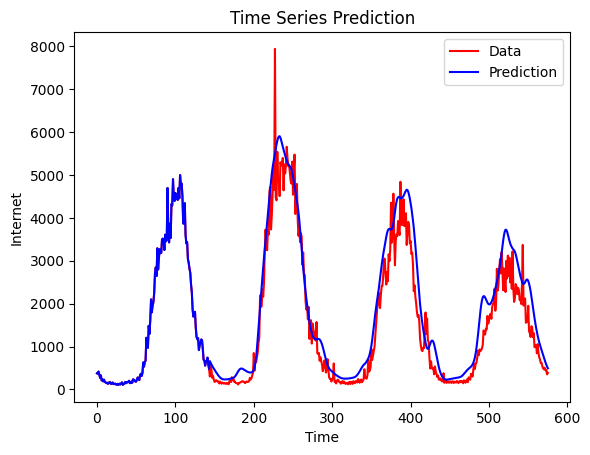

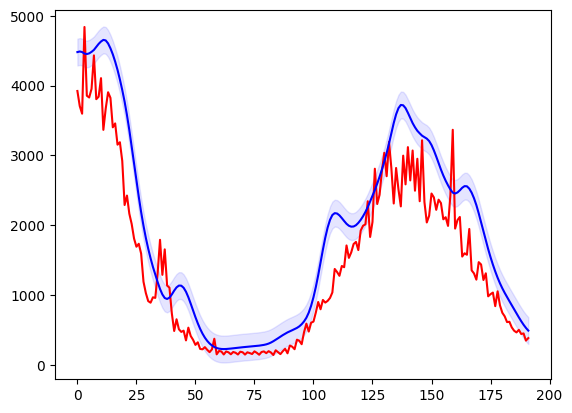

In [45]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Data')
plt.plot(allForecastedData, color = 'blue', label = 'Prediction')
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Prediction")
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

from matplotlib import pyplot as plt
import numpy as np

#some example data
x = np.arange(test_size)
# plt.title('Time slot vs mobile traffic')
# plt.ylabel('Internet traffic')
# plt.grid(True)
# plt.autoscale(axis='x', tight=True)
# plt.plot(test)
# plt.plot(x,predictions)
# plt.show()
y = predicted.reshape(-1,)
#some confidence interval
ci = 1.96 * np.std(predicted)/np.sqrt(len(x))

fig, ax = plt.subplots()
ax.plot(x,test_pul.reshape(-1,),'r')
ax.plot(x,y, 'b')
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

## Part 4 - Evaluation Metrics


In [46]:
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  599.0250120681151


In [47]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  358830.96508320543


In [48]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  49.373312723399465 %


In [49]:
mae = mean_absolute_error(test_pul, predicted)
print('MAE: ',mae)

MAE:  486.0122550112347


### Statistics of the test results.

In [50]:
# Fraction of under-estimated demands
violated = (predicted < test_pul)
violations = (test_pul - predicted)[violated]
print('Total violations:', sum(violated), '(%.2f%% of the test data points)' % (100*sum(violated)/test_size) )

Total violations: [13] (6.77% of the test data points)


In [51]:
print('Demand mean:', np.mean(test_pul))
print('Violation mean:', np.mean( violations ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations ) / np.mean(test_pul)) )

Demand mean: 1460.177548950116
Violation mean: 314.3365417145514
Violation excess: 21.53%


In [52]:
# Fraction of under-estimated demands
violated = (predicted + ci < test_pul)
violations = (test_pul - predicted - ci)[violated]
print('Total violations:', sum(violated), '(%.2f%% of the test data points)' % (100*sum(violated)/test_size) )

Total violations: [7] (3.65% of the test data points)


In [53]:
# from scipy import stats
# from scipy.stats import norm

In [54]:
# ci = stats.norm.interval(0.95,np.mean(predicted),np.std(predicted)/(1738**0.5))
# print('95% CI is:',np.round(beml_ci,6))